# General imports 

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [19]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, scipy.stats as st

In [20]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch.utils.data import Dataset
import torch.nn as nn
from torch import optim

In [21]:
import random

In [22]:
from icecream import ic

## Dataset 1 - NN1

In [23]:
num_samples = 6001

In [24]:
x1 = np.linspace(-3, 3, num_samples)
x1

array([-3.   , -2.999, -2.998, ...,  2.998,  2.999,  3.   ])

In [25]:
b = np.random.binomial(1, 0.5, num_samples)
b

array([0, 1, 0, ..., 1, 1, 0])

In [26]:
b.shape

(6001,)

In [27]:
z_mu = (b)*(7 * np.sin(x1)) + (1-b)*(6 * np.cos(x1*np.pi/2))

In [28]:
z_sigma = 1.5 * np.power((1 + np.exp(-x1)), -1)

In [29]:
z = np.random.normal(z_mu, z_sigma)

In [30]:
z.shape

(6001,)

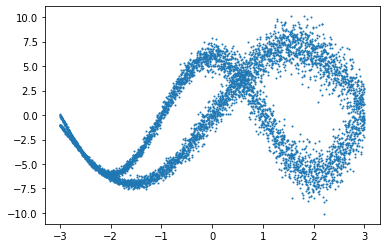

In [31]:
plt.scatter(x1, z, s=1)
plt.show()

## Dataset 2 - NN2

### As a function of y(z)

In [32]:
y_mu = (+0.1) * (z**2) + (0.0 * z) + 0

In [33]:
y_sigma = (b)* (0.15 * np.power((1 + np.exp(-0.4 * z)), -1)) + \
          (1-b) * (0.15 * np.power((1 + np.exp(0.4 * z)), -1))

In [34]:
y = np.random.normal(y_mu, y_sigma)

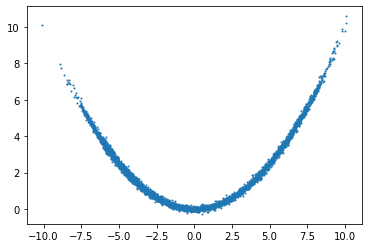

In [35]:
plt.scatter(z, y, s=1)
plt.show()

# Create Datasets

## Expand Dimensions of the data

In [36]:
print(x1.shape)
print(y.shape)
print(z.shape)
print(b.shape)

(6001,)
(6001,)
(6001,)
(6001,)


In [37]:
x_t = np.expand_dims(x1, 1)
y_t = np.expand_dims(y, 1)
z_t = np.expand_dims(z, 1)
ic(x_t.shape)
ic(y_t.shape)
ic(y_t.shape)

ic| x_t.shape: (6001, 1)
ic| y_t.shape: (6001, 1)
ic| y_t.shape: (6001, 1)


(6001, 1)

## Pytorch Dataset NN1

### Dataset 1 Class

In [ ]:
class toy_dataset_1(Dataset):
    def __init__(self, x_t, z_t):
        self.x_t = x_t
        self.z_t = z_t
    
    def __len__(self):
        return len(self.x_t)
    
    def __getitem__(self, index):
        x_val = self.x_t[index]
        z_val = self.z_t[index]
        sample = torch.Tensor(x_val)
        label = torch.Tensor(z_val)
        return (sample, label)
    

### Instantiate Dataset 1

In [39]:
toy_ds_1 = toy_dataset_1(x_t, z_t)

In [40]:
dataset1_len = len(toy_ds_1)
ic(dataset1_len)

ic| dataset1_len: 6001


6001

### Dataset 1 Sampler

In [ ]:
dataset_len = len(toy_ds_1)
print("dataset len", dataset_len)
indices = list(range(dataset_len))
print("indices len",len(indices))

In [41]:
valid_size = 0.30  # validation size 30% of the dataset
random.seed(10)
random.shuffle(indices)
# split
split = int(np.floor(valid_size * dataset_len))
train_idx, valid_idx = indices[split:], indices[:split]
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

NameError: name 'indices' is not defined

### Dataset 1 Dataloaders

In [ ]:
train_loader_1 = DataLoader(toy_ds_1,
                            batch_size=32,
                            sampler=train_sampler,
                            num_workers=32)

valid_loader_1 = DataLoader(toy_ds_1,
                            batch_size=32,
                            sampler=valid_sampler,
                            num_workers=32)

In [ ]:
dataiter = iter(train_loader_1)
batch_data, labels = dataiter.next()

In [ ]:
batch_data.shape

In [ ]:
batch_data.shape

In [ ]:
v = torch.randn(len(batch_data), 1)
ic(s.shape)

In [235]:
batch_data_f = torch.cat((batch_data, v), 1)
batch_data_f.shape

torch.Size([32, 2])

In [236]:
batch_data_f

tensor([[-1.6090,  0.5812],
        [-0.5000, -0.1189],
        [-2.6440, -0.0302],
        [ 1.8140,  0.2128],
        [ 2.3920, -0.5370],
        [ 0.0130, -1.1330],
        [ 0.6140,  0.0883],
        [ 0.0190,  0.7741],
        [ 0.8370, -0.0647],
        [ 0.8470, -0.9426],
        [-0.8420, -0.8102],
        [ 1.2200,  0.0176],
        [-0.9110, -0.9128],
        [ 2.8420, -0.9548],
        [ 2.5380, -0.1593],
        [ 2.3840,  0.0148],
        [ 1.7920, -1.8924],
        [ 0.0170, -0.5122],
        [ 2.5440, -0.0737],
        [-1.8820, -0.2007],
        [-2.3680,  0.6606],
        [-1.5260,  1.0103],
        [-0.5350,  0.3882],
        [-1.5280,  0.1053],
        [ 1.2560,  0.1394],
        [ 2.8110,  0.3012],
        [-2.6330,  0.3400],
        [-0.8480,  1.4612],
        [ 1.3310,  0.0925],
        [-1.0100, -0.3757],
        [ 1.4680, -0.9678],
        [-0.7700,  0.3234]])

## Pytorch Dataset NN2

### Dataset 2 Class

In [237]:
class toy_dataset_2(Dataset):
    def __init__(self, z_t, y_t):
        self.z_t = z_t
        self.y_t = y_t
    
    def __len__(self):
        return len(self.z_t)
    
    def __getitem__(self, index):
        z_val = self.z_t[index]
        y_val = self.y_t[index]
        sample = torch.Tensor(z_val)
        label = torch.Tensor(y_val)
        return (sample, label)

### Instantiate Dataset 2

In [238]:
toy_ds_2 = toy_dataset_1(z_t, y_t)

In [239]:
dataset2_len = len(toy_ds_2)
ic(dataset2_len)

ic| dataset2_len: 6001


6001

### Dataset 2 Sampler

In [ ]:
dataset_len = len(toy_ds_2)
print("dataset len", dataset_len)
indices = list(range(dataset_len))
print("indices len",len(indices))

In [240]:
valid_size = 0.30  # validation size 30% of the dataset
random.seed(10)
random.shuffle(indices)
# split
split = int(np.floor(valid_size * dataset_len))
train_idx, valid_idx = indices[split:], indices[:split]
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

### Dataset 2 Dataloaders

In [241]:
train_loader_2 = DataLoader(toy_ds_2,
                            batch_size=32,
                            sampler=train_sampler,
                            num_workers=32)

valid_loader_2 = DataLoader(toy_ds_2,
                            batch_size=32,
                            sampler=valid_sampler,
                            num_workers=32)

# Probabilistic NN for Regression

## Probabilistic LV NN

In [249]:
class SimpleProbNNLV(nn.Module):
    def __init__(self, input_dim=2, output_dim=1):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, 64)
        
        self.fc2 = nn.Linear(64, 32)
        
        self.fc3_mean = nn.Linear(32, 16)
        self.fc3_logvar = nn.Linear(32, 16)        

        self.mean = nn.Linear(16, output_dim)
        self.logvar = nn.Linear(16, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x_mean = self.fc3_mean(x)
        x_mean = F.relu(x_mean)

        x_logvar = self.fc3_logvar(x)
        x_logvar = F.relu(x_logvar)

        output_mean = self.mean(x_mean)
        output_logvar = self.logvar(x_logvar)

        return output_mean, output_logvar

## Heteroscedastic Loss Function

In [243]:
class Heteroscedastic_Loss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction

    def forward(self, predicted_mean, predicted_logvar, target_mean):
        heteroscedastic_loss = (0.5 * predicted_logvar.neg().exp() * torch.pow(predicted_mean - target_mean, 2)) + (0.5 * predicted_logvar)
        if self.reduction == 'sum':
            return torch.sum(heteroscedastic_loss)
        elif self.reduction == 'mean':
            return torch.mean(heteroscedastic_loss)
        elif self.reduction == 'none':
            return heteroscedastic_loss
        else:
            raise ValueError("Loss reduction option not found")

## Train NN

In [244]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ic(device)

ic| device: device(type='cuda')


device(type='cuda')

In [250]:
prob_model = SimpleProbNNLV().to(device)
ic(prob_model)

ic| prob_model: SimpleProbNNLV(
                  (fc1): Linear(in_features=2, out_features=64, bias=True)
                  (fc2): Linear(in_features=64, out_features=32, bias=True)
                  (fc3_mean): Linear(in_features=32, out_features=16, bias=True)
                  (fc3_logvar): Linear(in_features=32, out_features=16, bias=True)
                  (mean): Linear(in_features=16, out_features=1, bias=True)
                  (logvar): Linear(in_features=16, out_features=1, bias=True)
                )


SimpleProbNNLV(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3_mean): Linear(in_features=32, out_features=16, bias=True)
  (fc3_logvar): Linear(in_features=32, out_features=16, bias=True)
  (mean): Linear(in_features=16, out_features=1, bias=True)
  (logvar): Linear(in_features=16, out_features=1, bias=True)
)

In [251]:
optimizer = optim.Adam(prob_model.parameters(), lr=0.001, weight_decay=1e-5, eps=1e-7)
# optimizer = optim.Adam(prob_model.parameters(), lr=0.001)
loss_function = Heteroscedastic_Loss(reduction="sum")

In [256]:
train_losses = []
test_losses = []

test_loss_min = np.Inf # set initial "min" to infinity

epochs = 50

In [259]:
for epoch in range(0, epochs + 1):
    ################
    #     Train    #
    ################
    prob_model.train()
    train_loss = 0
    #average_epoch_loss = train(model, optimizer, device, train_loader, policy_loss, epoch, exp_cfg)
    for batch_idx, (x_b, y_b) in enumerate(train_loader_1):
        s = torch.randn(len(x_b), 1)
        x_b = torch.cat((x_b, s), 1)
        x_b = x_b.to(device)
        y_b = y_b.to(device)
        optimizer.zero_grad()
        mean_hat_batch, logvar_hat_batch = prob_model(x_b)
        loss = loss_function(mean_hat_batch, logvar_hat_batch, y_b) # Heteroscedastic Loss
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * len(x_b),
                                                                           len(train_loader_1.sampler),
                                                                           100. * batch_idx / len(train_loader_1),
                                                                           loss.item() / len(x_b)))

    average_epoch_loss = train_loss / (len(train_loader_1) * train_loader_1.batch_size)
    train_losses.append(average_epoch_loss)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, average_epoch_loss))    
    print()
    #####################
    #        Test       #
    #####################
    prob_model.eval()
    test_loss = 0

    with torch.no_grad():
        for i, (x_b, y_b) in enumerate(valid_loader_1):
            s = torch.randn(len(x_b), 1)
            x_b = torch.cat((x_b, s), 1)
            x_b = x_b.to(device)
            y_b = y_b.to(device)
            mean_hat_batch, logvar_hat_batch = prob_model(x_b)
  
            test_loss += loss_function(mean_hat_batch, logvar_hat_batch, y_b).item() # Heteroscedastic Loss   

    average_epoch_test_loss = test_loss / ((len(valid_loader_1) - 1) * valid_loader_1.batch_size)
    test_losses.append(average_epoch_test_loss)
    print('====> Test set epoch {} loss: {:.4f}'.format(epoch, average_epoch_test_loss))
    print()
    ################
    # Save Model   #
    ################
    if average_epoch_test_loss <= test_loss_min:
        print('Test loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(test_loss_min,average_epoch_test_loss))
        if epoch > 0:
            torch.save(prob_model.state_dict(), 'toy_ds_1_model_last_best_checkpoint_epoch.pt')
        test_loss_min = average_epoch_test_loss     

    print("\r\n")

Train Epoch: 0 [0/4201 (0%)]	Loss: 1.704864
Train Epoch: 0 [320/4201 (8%)]	Loss: 1.247679
Train Epoch: 0 [640/4201 (15%)]	Loss: 1.492059
Train Epoch: 0 [960/4201 (23%)]	Loss: 1.143384
Train Epoch: 0 [1280/4201 (30%)]	Loss: 1.167152
Train Epoch: 0 [1600/4201 (38%)]	Loss: 1.253519
Train Epoch: 0 [1920/4201 (45%)]	Loss: 1.231502
Train Epoch: 0 [2240/4201 (53%)]	Loss: 1.471963
Train Epoch: 0 [2560/4201 (61%)]	Loss: 1.431082
Train Epoch: 0 [2880/4201 (68%)]	Loss: 1.394224
Train Epoch: 0 [3200/4201 (76%)]	Loss: 1.442051
Train Epoch: 0 [3520/4201 (83%)]	Loss: 1.297523
Train Epoch: 0 [3840/4201 (91%)]	Loss: 1.129148
Train Epoch: 0 [4160/4201 (98%)]	Loss: 1.463335
====> Epoch: 0 Average loss: 1.3986

====> Test set epoch 0 loss: 1.4278

Test loss decreased (1.451012 --> 1.427751). Saving model ...


Train Epoch: 1 [0/4201 (0%)]	Loss: 1.242493
Train Epoch: 1 [320/4201 (8%)]	Loss: 1.378404
Train Epoch: 1 [640/4201 (15%)]	Loss: 1.521742
Train Epoch: 1 [960/4201 (23%)]	Loss: 1.221254
Train Epoch: 1

Train Epoch: 10 [4160/4201 (98%)]	Loss: 1.330578
====> Epoch: 10 Average loss: 1.2743

====> Test set epoch 10 loss: 1.3209

Test loss decreased (1.338397 --> 1.320936). Saving model ...


Train Epoch: 11 [0/4201 (0%)]	Loss: 1.420105
Train Epoch: 11 [320/4201 (8%)]	Loss: 1.430507
Train Epoch: 11 [640/4201 (15%)]	Loss: 1.409873
Train Epoch: 11 [960/4201 (23%)]	Loss: 1.156774
Train Epoch: 11 [1280/4201 (30%)]	Loss: 1.226697
Train Epoch: 11 [1600/4201 (38%)]	Loss: 0.974462
Train Epoch: 11 [1920/4201 (45%)]	Loss: 1.269598
Train Epoch: 11 [2240/4201 (53%)]	Loss: 1.364130
Train Epoch: 11 [2560/4201 (61%)]	Loss: 0.994364
Train Epoch: 11 [2880/4201 (68%)]	Loss: 1.376669
Train Epoch: 11 [3200/4201 (76%)]	Loss: 1.018310
Train Epoch: 11 [3520/4201 (83%)]	Loss: 1.282622
Train Epoch: 11 [3840/4201 (91%)]	Loss: 1.477336
Train Epoch: 11 [4160/4201 (98%)]	Loss: 1.312559
====> Epoch: 11 Average loss: 1.2678

====> Test set epoch 11 loss: 1.3169

Test loss decreased (1.320936 --> 1.316941). Saving model

Train Epoch: 21 [1920/4201 (45%)]	Loss: 1.339085
Train Epoch: 21 [2240/4201 (53%)]	Loss: 0.785987
Train Epoch: 21 [2560/4201 (61%)]	Loss: 1.063364
Train Epoch: 21 [2880/4201 (68%)]	Loss: 1.094851
Train Epoch: 21 [3200/4201 (76%)]	Loss: 1.279424
Train Epoch: 21 [3520/4201 (83%)]	Loss: 1.180849
Train Epoch: 21 [3840/4201 (91%)]	Loss: 1.468191
Train Epoch: 21 [4160/4201 (98%)]	Loss: 1.371288
====> Epoch: 21 Average loss: 1.1274

====> Test set epoch 21 loss: 1.2689



Train Epoch: 22 [0/4201 (0%)]	Loss: 1.279621
Train Epoch: 22 [320/4201 (8%)]	Loss: 1.140152
Train Epoch: 22 [640/4201 (15%)]	Loss: 1.302328
Train Epoch: 22 [960/4201 (23%)]	Loss: 1.373721
Train Epoch: 22 [1280/4201 (30%)]	Loss: 0.866856
Train Epoch: 22 [1600/4201 (38%)]	Loss: 1.026789
Train Epoch: 22 [1920/4201 (45%)]	Loss: 0.854925
Train Epoch: 22 [2240/4201 (53%)]	Loss: 1.209901
Train Epoch: 22 [2560/4201 (61%)]	Loss: 1.307766
Train Epoch: 22 [2880/4201 (68%)]	Loss: 1.000922
Train Epoch: 22 [3200/4201 (76%)]	Loss: 0.776149

Train Epoch: 32 [1920/4201 (45%)]	Loss: 0.623445
Train Epoch: 32 [2240/4201 (53%)]	Loss: 1.355931
Train Epoch: 32 [2560/4201 (61%)]	Loss: 1.413798
Train Epoch: 32 [2880/4201 (68%)]	Loss: 1.198515
Train Epoch: 32 [3200/4201 (76%)]	Loss: 1.119272
Train Epoch: 32 [3520/4201 (83%)]	Loss: 1.078979
Train Epoch: 32 [3840/4201 (91%)]	Loss: 1.015366
Train Epoch: 32 [4160/4201 (98%)]	Loss: 1.162291
====> Epoch: 32 Average loss: 1.0900

====> Test set epoch 32 loss: 1.1646

Test loss decreased (1.164920 --> 1.164599). Saving model ...


Train Epoch: 33 [0/4201 (0%)]	Loss: 1.209550
Train Epoch: 33 [320/4201 (8%)]	Loss: 1.182992
Train Epoch: 33 [640/4201 (15%)]	Loss: 1.107595
Train Epoch: 33 [960/4201 (23%)]	Loss: 1.299263
Train Epoch: 33 [1280/4201 (30%)]	Loss: 1.134508
Train Epoch: 33 [1600/4201 (38%)]	Loss: 1.422591
Train Epoch: 33 [1920/4201 (45%)]	Loss: 1.347294
Train Epoch: 33 [2240/4201 (53%)]	Loss: 1.176274
Train Epoch: 33 [2560/4201 (61%)]	Loss: 0.978160
Train Epoch: 33 [2880/4201 (68%)]	L

Train Epoch: 43 [2240/4201 (53%)]	Loss: 1.293632
Train Epoch: 43 [2560/4201 (61%)]	Loss: 1.141333
Train Epoch: 43 [2880/4201 (68%)]	Loss: 1.386421
Train Epoch: 43 [3200/4201 (76%)]	Loss: 0.807819
Train Epoch: 43 [3520/4201 (83%)]	Loss: 1.199798
Train Epoch: 43 [3840/4201 (91%)]	Loss: 0.561978
Train Epoch: 43 [4160/4201 (98%)]	Loss: 1.298768
====> Epoch: 43 Average loss: 1.0727

====> Test set epoch 43 loss: 1.1880



Train Epoch: 44 [0/4201 (0%)]	Loss: 1.079495
Train Epoch: 44 [320/4201 (8%)]	Loss: 0.873300
Train Epoch: 44 [640/4201 (15%)]	Loss: 1.283284
Train Epoch: 44 [960/4201 (23%)]	Loss: 1.266746
Train Epoch: 44 [1280/4201 (30%)]	Loss: 1.021448
Train Epoch: 44 [1600/4201 (38%)]	Loss: 1.153744
Train Epoch: 44 [1920/4201 (45%)]	Loss: 0.724468
Train Epoch: 44 [2240/4201 (53%)]	Loss: 1.036037
Train Epoch: 44 [2560/4201 (61%)]	Loss: 1.145897
Train Epoch: 44 [2880/4201 (68%)]	Loss: 0.737279
Train Epoch: 44 [3200/4201 (76%)]	Loss: 1.002283
Train Epoch: 44 [3520/4201 (83%)]	Loss: 1.044993

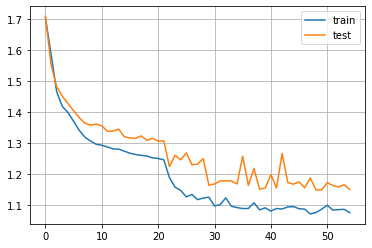

In [260]:
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.grid()
plt.show()

In [261]:
test_losses

[1.7082243567066533,
 1.552469749535833,
 1.4811226331761904,
 1.451011594917093,
 1.4277509089027132,
 1.4044184274971485,
 1.3823236652782984,
 1.364389571760382,
 1.3580643545304025,
 1.361635999487979,
 1.356052778661251,
 1.338396579027176,
 1.338999712041446,
 1.34522393611925,
 1.3209356388875417,
 1.316940744540521,
 1.3158012894647462,
 1.3235532779778754,
 1.3091943466237612,
 1.315745357956205,
 1.306600340775081,
 1.3079128009932381,
 1.2250705393297332,
 1.2611721535878522,
 1.2465035053236144,
 1.2688997169690472,
 1.2306822293571062,
 1.2327798892344748,
 1.2504143565893173,
 1.164919619315437,
 1.1689806995647294,
 1.178551840462855,
 1.179144486784935,
 1.178554192185402,
 1.1689720999981676,
 1.2578872218728065,
 1.1645993265722479,
 1.2182301341422967,
 1.1519802654428142,
 1.1560233682394028,
 1.1988738125988416,
 1.1559703813067503,
 1.266944975725242,
 1.1737515931682927,
 1.1683360833142484,
 1.1758440472185612,
 1.1563843853239502,
 1.1880315680588995,
 1.149840

# Test Model

In [321]:
t = torch.ones((256, 1))

In [322]:
t_input = t * 2.0

In [323]:
t_input.shape

torch.Size([256, 1])

In [324]:
v = torch.randn(len(t_input), 1)

In [325]:
t_input = torch.cat((t_input, v), 1)
t_input.shape

torch.Size([256, 2])

__send inputo to gpu__

In [326]:
t_input = t_input.to(device)

In [327]:
prob_model.eval()

SimpleProbNNLV(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3_mean): Linear(in_features=32, out_features=16, bias=True)
  (fc3_logvar): Linear(in_features=32, out_features=16, bias=True)
  (mean): Linear(in_features=16, out_features=1, bias=True)
  (logvar): Linear(in_features=16, out_features=1, bias=True)
)

In [328]:
with torch.no_grad():
    mean_hat_batch, logvar_hat_batch = prob_model(t_input)

In [329]:
std = torch.sqrt(torch.exp(logvar_hat_batch))

In [330]:
output_samples = torch.normal(mean_hat_batch, std)
output_samples.shape

torch.Size([256, 1])

In [331]:
output_samples_np = output_samples.cpu().numpy()
output_samples_np.shape

(256, 1)

In [332]:
input_samples = t_input[:, 0].unsqueeze(1)
input_samples_np = input_samples.cpu().numpy()
input_samples_np.shape

(256, 1)

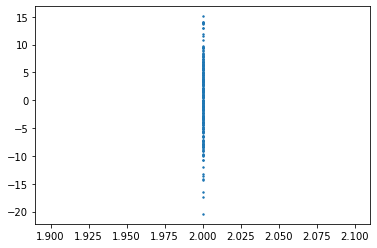

In [333]:
plt.scatter(input_samples_np, output_samples_np, s=2)